<a href="https://colab.research.google.com/github/LIVECODING-2025/Saruto/blob/main/Analisis_Sentimen_NaiveBayes_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sastrawi
!pip install swifter
!pip install transformers
!pip install wordcloud
!pip install nltk
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=7beed0db819ca4e627ba7ac543380a1ddd87635380f5214391558f14df084c4f
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import swifter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

import nltk
import string
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_id = '/content/drive/MyDrive/Data Science/Live Coding 2025/komentar_berlabel.csv'

In [5]:
df = pd.read_csv(file_id)

In [6]:
df

,komentar,label
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2
2,NYESEL PILIH PRABOWO,0
3,ekspresinya so iye\npembahasannya walaweee,0
4,Yang komen kenapa parah banget literasinya?mes...,2
...,...,...
5992,Petani di desa belum merasakan kebijakan itu p...,1
5993,Power of vegasus,0
5994,jaka sembung bawa golok,0
5995,pak...\ntolong lah HAPUS PROGRAM MAKAN GRATIS ...,2


In [ ]:
label_mapping = {
    0: 'negatif',
    1: 'netral',
    2: 'positif'
}
df['label_sentiment'] = df['label'].map(label_mapping)

In [ ]:
df

,komentar,label,label_sentiment
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif
2,NYESEL PILIH PRABOWO,0,negatif
3,ekspresinya so iye\npembahasannya walaweee,0,negatif
4,Yang komen kenapa parah banget literasinya?mes...,2,positif
...,...,...,...
5992,Petani di desa belum merasakan kebijakan itu p...,1,netral
5993,Power of vegasus,0,negatif
5994,jaka sembung bawa golok,0,negatif
5995,pak...\ntolong lah HAPUS PROGRAM MAKAN GRATIS ...,2,positif


# **Pre Procesing**

In [7]:
def case_folding(text):
    text = text.lower()
    return text
df['casefolding']= df['komentar'].apply(lambda x: case_folding(x))

In [8]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # simbol & pictogram
        u"\U0001F680-\U0001F6FF"  # transport & map symbol
        u"\U0001F1E0-\U0001F1FF"  # flags (bendera)
        u"\U00002700-\U000027BF"  # simbol lainnya
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [9]:
#Cleansing Data
def cleansing(text):
    text = remove_emoji(text) #hapus emoji
    text = re.sub('\[.*?\]', '', text) #Menghilangkan tanda kurung
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Menghilangkan Tanda Baca
    text = re.sub('\w*\d\w*', '', text) #Menghilangkan Special Karakter
    text = re.sub('\s+[a-zA-Z]\s+', '', text) #Menghilangkan Single Character
    text = re.sub(r"http\S+", "", text, flags=re.MULTILINE) #Menghilangkan Link
    text = re.sub(r'\B#\S+','', text)  #Menghilangkan Hashtag
    text = re.sub(r'\s+', ' ', text, flags=re.I) #Mengganti Multiple Spaces ke Single Spaces
    text = text.strip() #Menghilangkan Spaces di awal
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    return text
df['cleansing'] = df['casefolding'].apply(lambda x: x.split())

In [19]:
def tokenization(text):
    tokens = re.split(r'\W+', text)
    tokens = [word for word in tokens if word]
    return tokens

df['tokenizing'] = df['cleansing'].apply(lambda x: tokenization(str(x)))

In [20]:
df

,komentar,label,casefolding,cleansing,tokenizing
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,sangat keren! meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,"[sangat, keren!, meraih, kemenangan, besar, di...","[sangat, keren, meraih, kemenangan, besar, di,..."
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,"[🔥𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, 🔥, memang, layak, jadi,...","[𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, memang, layak, jadi, pil..."
2,NYESEL PILIH PRABOWO,0,nyesel pilih prabowo,"[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]"
3,ekspresinya so iye\npembahasannya walaweee,0,ekspresinya so iye\npembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]"
4,Yang komen kenapa parah banget literasinya?mes...,2,yang komen kenapa parah banget literasinya?mes...,"[yang, komen, kenapa, parah, banget, literasin...","[yang, komen, kenapa, parah, banget, literasin..."
...,...,...,...,...,...
5992,Petani di desa belum merasakan kebijakan itu p...,1,petani di desa belum merasakan kebijakan itu p...,"[petani, di, desa, belum, merasakan, kebijakan...","[petani, di, desa, belum, merasakan, kebijakan..."
5993,Power of vegasus,0,power of vegasus,"[power, of, vegasus]","[power, of, vegasus]"
5994,jaka sembung bawa golok,0,jaka sembung bawa golok,"[jaka, sembung, bawa, golok]","[jaka, sembung, bawa, golok]"
5995,pak...\ntolong lah HAPUS PROGRAM MAKAN GRATIS ...,2,pak...\ntolong lah hapus program makan gratis ...,"[pak..., tolong, lah, hapus, program, makan, g...","[pak, tolong, lah, hapus, program, makan, grat..."


In [21]:
def stopwords_removal(words):

    list_stopwords = ['yang', 'di', 'dan', 'itu', 'dengan', 'atau','untuk', 'dari', 'pada']
    return [word for word in words if word not in list_stopwords]

df['stop_removal']= df['tokenizing'].apply(stopwords_removal)

In [22]:
df

,komentar,label,casefolding,cleansing,tokenizing,stop_removal
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,sangat keren! meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,"[sangat, keren!, meraih, kemenangan, besar, di...","[sangat, keren, meraih, kemenangan, besar, di,...","[sangat, keren, meraih, kemenangan, besar, 𝐏, ..."
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,"[🔥𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, 🔥, memang, layak, jadi,...","[𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, memang, layak, jadi, pil...","[𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, memang, layak, jadi, pil..."
2,NYESEL PILIH PRABOWO,0,nyesel pilih prabowo,"[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]"
3,ekspresinya so iye\npembahasannya walaweee,0,ekspresinya so iye\npembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]"
4,Yang komen kenapa parah banget literasinya?mes...,2,yang komen kenapa parah banget literasinya?mes...,"[yang, komen, kenapa, parah, banget, literasin...","[yang, komen, kenapa, parah, banget, literasin...","[komen, kenapa, parah, banget, literasinya, me..."
...,...,...,...,...,...,...
5992,Petani di desa belum merasakan kebijakan itu p...,1,petani di desa belum merasakan kebijakan itu p...,"[petani, di, desa, belum, merasakan, kebijakan...","[petani, di, desa, belum, merasakan, kebijakan...","[petani, desa, belum, merasakan, kebijakan, pa..."
5993,Power of vegasus,0,power of vegasus,"[power, of, vegasus]","[power, of, vegasus]","[power, of, vegasus]"
5994,jaka sembung bawa golok,0,jaka sembung bawa golok,"[jaka, sembung, bawa, golok]","[jaka, sembung, bawa, golok]","[jaka, sembung, bawa, golok]"
5995,pak...\ntolong lah HAPUS PROGRAM MAKAN GRATIS ...,2,pak...\ntolong lah hapus program makan gratis ...,"[pak..., tolong, lah, hapus, program, makan, g...","[pak, tolong, lah, hapus, program, makan, grat...","[pak, tolong, lah, hapus, program, makan, grat..."


In [23]:
#Stemming
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['stop_removal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['stemming'] = df['stop_removal'].apply(get_stemmed_term)
df.head()

Streaming output truncated to the last 5000 lines.
cut : cut
other : other
channels : channels
sudahi : sudah
adudomba : adudomba
intropeksi : intropeksi
kitaaaa : kitaaaa
tapiketika : tapiketika
urusannya : urus
sadari : sadar
tangannya : tangan
awal2 : awal2
moga : moga
varian : varian
disiplin : disiplin
trkadang : trkadang
brasa : brasa
eyangnya : eyang
dibilangin : dibilangin
nyela : nyela
briefing : briefing
kelen : kelen
aba2 : aba2
hhhh : hhhh
kuesioner : kuesioner
mengkambing : kambing
hitamkan : hitam
abad : abad
dijajah : jajah
surah : surah
nam : nam
ayat : ayat
123 : 123
lihatlah : lihat
statistik : statistik
mlompong : mlompong
reforma : reforma
industrilialisasi : industrilialisasi
khusunya : khusunya
hapuskan : hapus
kebudayaan : budaya
feodalisme : feodalisme
wakili : wakil
mks : mks
memerintah : perintah
terpampang : pampang
artis2 : artis2
endors : endors
terketuk : ketuk
blk : blk
nitip : nitip
ngatasi : ngatasi
diprediksi : prediksi
cepetin : cepetin
nduddd : ndudd

,komentar,label,casefolding,cleansing,tokenizing,stop_removal,stemming
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,sangat keren! meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,"[sangat, keren!, meraih, kemenangan, besar, di...","[sangat, keren, meraih, kemenangan, besar, di,...","[sangat, keren, meraih, kemenangan, besar, 𝐏, ...","[sangat, keren, raih, menang, besar, , , , , ,..."
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,"[🔥𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, 🔥, memang, layak, jadi,...","[𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, memang, layak, jadi, pil...","[𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, memang, layak, jadi, pil...","[, , , , , , , memang, layak, jadi, pilih, utama]"
2,NYESEL PILIH PRABOWO,0,nyesel pilih prabowo,"[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]"
3,ekspresinya so iye\npembahasannya walaweee,0,ekspresinya so iye\npembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresi, so, iye, bahas, walaweee]"
4,Yang komen kenapa parah banget literasinya?mes...,2,yang komen kenapa parah banget literasinya?mes...,"[yang, komen, kenapa, parah, banget, literasin...","[yang, komen, kenapa, parah, banget, literasin...","[komen, kenapa, parah, banget, literasinya, me...","[komen, kenapa, parah, banget, literasinya, me..."


In [25]:
def normalisasi(document):
  return ' '.join(document)
df['normalisasi'] = df['stemming'].apply(normalisasi)
df.head()

,komentar,label,casefolding,cleansing,tokenizing,stop_removal,stemming,normalisasi
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,sangat keren! meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,"[sangat, keren!, meraih, kemenangan, besar, di...","[sangat, keren, meraih, kemenangan, besar, di,...","[sangat, keren, meraih, kemenangan, besar, 𝐏, ...","[sangat, keren, raih, menang, besar, , , , , ,...",sangat keren raih menang besar langsung...
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,"[🔥𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, 🔥, memang, layak, jadi,...","[𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, memang, layak, jadi, pil...","[𝗣, 𝗟, 𝗨, 𝗧, 𝗢, 𝟴, 𝟴, memang, layak, jadi, pil...","[, , , , , , , memang, layak, jadi, pilih, utama]",memang layak jadi pilih utama
2,NYESEL PILIH PRABOWO,0,nyesel pilih prabowo,"[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]",nyesel pilih prabowo
3,ekspresinya so iye\npembahasannya walaweee,0,ekspresinya so iye\npembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresi, so, iye, bahas, walaweee]",ekspresi so iye bahas walaweee
4,Yang komen kenapa parah banget literasinya?mes...,2,yang komen kenapa parah banget literasinya?mes...,"[yang, komen, kenapa, parah, banget, literasin...","[yang, komen, kenapa, parah, banget, literasin...","[komen, kenapa, parah, banget, literasinya, me...","[komen, kenapa, parah, banget, literasinya, me...",komen kenapa parah banget literasinya meski p ...


In [26]:
slang_dict = ({
    'bener': 'benar',
    'setuju': 'setuju',
    'cocok': 'sesuai',
    'keren': 'hebat',
    'mantap': 'baik',
    'tepuk tangan': 'apresiasi',
    'oke': 'baik',
    'bagus': 'positif',
    'sukses': 'berhasil',
    'semangat': 'antusias',
    'hebat': 'luar biasa',
    'wajib': 'perlu',
    'top': 'terbaik',
    'gokil': 'hebat',
    'diperjuangkan': 'diperjuangkan',
    'yakin': 'percaya',
    'berharap': 'mengharapkan',
    'nyata': 'terbukti',
    'senang': 'bahagia',
    'maju': 'berkembang',
    'berhasil': 'sukses',
    'sangat setuju': 'setuju sekali',
    'terimakasih': 'terima kasih',
    'berbahagia': 'senang',
    'klop': 'cocok',
    'langsung': 'segera',
    'inovasi': 'perubahan baru',
    'komitmen': 'tanggung jawab',
    'dapat diterima': 'memadai',
    'positif': 'baik',
    'bisa': 'mampu',
    'mendukung': 'mendukung',
    'percaya diri': 'yakin',
    'harapan': 'keinginan',
    'terbaik': 'paling baik',
    'indah': 'bagus',
    'sejahtera': 'makmur',
    'kecewa': 'frustrasi',
    'tidak setuju': 'kurang setuju',
    'masalah': 'permasalahan',
    'kritik': 'komentar',
    'serius': 'penting',
    'bermain politik': 'mengambil langkah politik',
    'korupsi': 'penyalahgunaan',
    'penuh tekanan': 'tertekan',
    'rakyat': 'masyarakat',
    'bangga': 'terhormat',
    'optimis': 'positif',
    'percaya': 'yakin',
    'perhatian': 'peduli',
    'bagus banget': 'sangat baik',
    'sangat penting': 'krusial',
    'belum jelas': 'belum pasti',
    'risih': 'tidak nyaman',
    'menginginkan': 'berharap',
    'realistis': 'dapat diterima',
    'kinerja': 'hasil kerja',
    'politik': 'politik',
    'kompromi': 'penyelesaian',
    'aspirasi': 'keinginan',
    'ke depan': 'untuk masa depan',
    'tidak nyaman': 'kurang menyenangkan',
    'tanggapan': 'respon',
    'perubahan': 'transformasi',
    'progres': 'kemajuan',
    'solusi': 'jawaban',
    'alternatif': 'pilihan',
    'berani': 'tangguh',
    'tegas': 'jelas',
    'harus': 'perlu',
    'rencana': 'strategi',
    'kedepannya': 'di masa depan',
    'bagus lah': 'oke lah',
    'jadi lebih baik': 'makin baik',
    'kerja keras': 'usaha keras',
    'asli': 'benar-benar',
    'selesai': 'tuntas',
    'tanggung jawab': 'amanah',
    'aman': 'terjaga',
    'berat': 'sulit',
    'terlalu lama': 'proses lama',
    'perbaikan': 'peningkatan',
    'menyelesaikan': 'mengakhiri',
    'wajib dilakukan': 'perlu diadakan',
    'baru': 'fresh',
    'terlalu cepat': 'terburu-buru',
    'terlalu lambat': 'terlalu lama',
    'kecewa banget': 'sangat kecewa',
    'kerja sama': 'kolaborasi',
    'apresiasi': 'penghargaan',
    'penurunan': 'kemunduran',
    'kemajuan': 'progres',
    'tindak lanjut': 'lanjutan',
    'transparansi': 'keterbukaan',
    'terus terang': 'jujur',
    'kontroversial': 'perdebatan',
    'bermanfaat': 'berguna',
    'di luar dugaan': 'terkejut',
    'terlalu ambisius': 'terlalu berlebihan',
    'agresif': 'berani',
    'strategis': 'penting',
    'komunikasi': 'interaksi',
    'positif sekali': 'sangat baik',
    'kurang transparan': 'tidak terbuka',
    'mendalam': 'detail',
    'pragmatis': 'praktis',
    'pertumbuhan': 'perkembangan',
    'tidak adil': 'kurang seimbang',
    'berkelanjutan': 'terus-menerus',
    'ideal': 'terbaik',
    'tangguh': 'kuat',
    'berkelanjutan': 'terus menerus',
    'fokus': 'terarah',
    'integritas': 'kejujuran',
    'progresif': 'berkembang',
    'hasil maksimal': 'pencapaian tinggi',
})

    # tambahkan lebih banyak sesuai kebutuhan

# Fungsi normalisasi
def normalize_text(text):
    # Pisahkan teks menjadi kata-kata
    words = text.split()

    # Normalisasi setiap kata
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]

    # Gabungkan kata-kata kembali menjadi satu string
    normalized_text = ' '.join(normalized_words)

    return normalized_text

df['normalisasi'] = df['normalisasi'].apply(normalize_text)

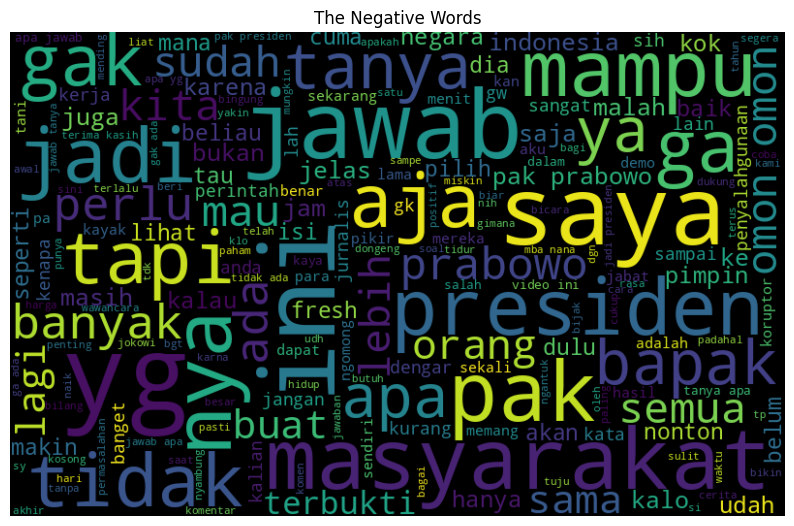

In [27]:
negative_text = df[df['label'] == 0]['normalisasi'].dropna().astype(str)
negative_text = ' '.join(negative_text)

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

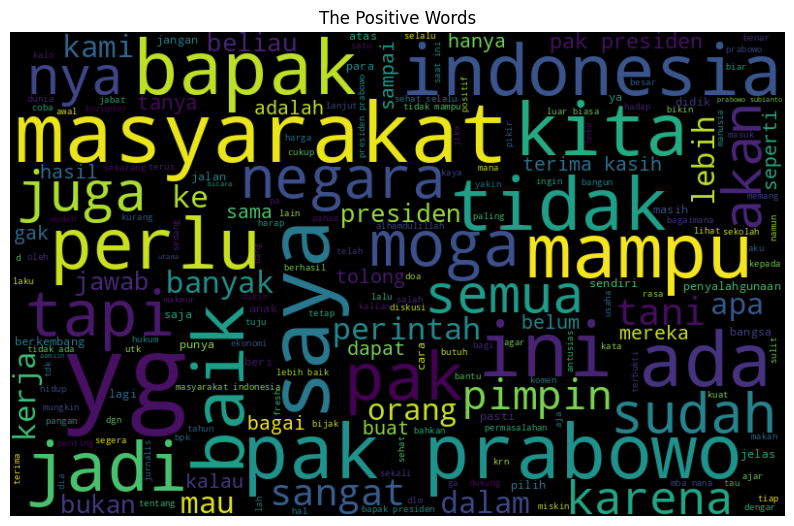

In [29]:
positive_text = df[df['label'] == 2]['normalisasi'].dropna().astype(str)
positive_text = ' '.join(positive_text)

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(positive_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

In [45]:
tfidf = TfidfVectorizer(max_features=3000)  # kamu bisa sesuaikan jumlah fitur
X = tfidf.fit_transform(df['normalisasi'])      # input teks
y = df['label']                              # label sentimen

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [48]:
y_pred = model.predict(X_test)

# Akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:", round(accuracy * 100, 2), "%")

# Laporan klasifikasi lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Akurasi: 76.83 %

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87       888
           1       0.88      0.04      0.08       159
           2       0.91      0.19      0.31       153

    accuracy                           0.77      1200
   macro avg       0.85      0.41      0.42      1200
weighted avg       0.80      0.77      0.69      1200


Confusion Matrix:
[[886   0   2]
 [151   7   1]
 [123   1  29]]
